# Part 2 Logistic Regression in TensorFlow

## 2.1 and 2.2 Building the Computational Graph and Implementing Stochastic Gradient Descent

In [1]:
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
tf.disable_v2_behavior() 
!git clone https://github.com/Marneus981/Ece421stuff.git

Instructions for updating:
non-resource variables are not supported in the long term
Cloning into 'Ece421stuff'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [2]:
#Helper function to calculate accuracy
def accuracy(predictions, labels):
    return (np.sum((predictions>=0.5)==labels) / np.shape(predictions)[0])
#Helper function to load data (provided)
def loadData():
    with np.load('/content/Ece421stuff/notMNIST.npz') as data :
        Data, Target = data ['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        #Set seed
        np.random.seed(124)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

#Build graph (main part of Part2 of the Programming Assignment 1)
def buildGraph(batch_size_ = 500, beta1=None, beta2=None, epsilon=None, learning_rate=None):
    #Define variables used, as well as the graph
    lambda_ = 0
    batch_size = batch_size_
    n_epochs = 700
    graph = tf.Graph()
    #Graph
    with graph.as_default():
        # Initialization of placeholders and variables
        x = tf.placeholder(tf.float32, shape=(batch_size, 784))
        y = tf.placeholder(tf.float32, shape=(batch_size, 1))
        W = tf.Variable(tf.truncated_normal(shape=(784, 1), mean=0.0, stddev=0.5, dtype=tf.float32, seed =None, name=None))
        b = tf.Variable(tf.zeros(1))
        #Valdiation data and labels
        valid_data = tf.placeholder(tf.float32, shape=(100, 784))
        valid_label = tf.placeholder(tf.int8, shape=(100, 1))
        #Test data and labels
        test_data = tf.placeholder(tf.float32, shape=(145, 784))
        test_label = tf.placeholder(tf.int8, shape=(145, 1))

        #Set seed
        tf.set_random_seed(124)
        
        # Loss function, L2 Regularization
        
        #Training
        logits = tf.matmul(x, W) + b 
        train_prediction = tf.sigmoid(logits)
        loss = tf.losses.sigmoid_cross_entropy(y, train_prediction)
        regularizer = tf.nn.l2_loss(W)
        loss = loss + lambda_/2.0 * regularizer
        # Optimizer for training
        optimizer = tf.train.AdamOptimizer(beta1=beta1, beta2=beta2, epsilon=epsilon, learning_rate=learning_rate).minimize(loss)
        
        #Output for Validation and Testing sets
        
        #Validation
        logits = tf.matmul(valid_data,W) + b 
        valid_prediction = tf.sigmoid(tf.matmul(valid_data, W) + b)
        valid_loss = tf.losses.sigmoid_cross_entropy(valid_label, valid_prediction)
        regularizer = tf.nn.l2_loss(W)
        valid_loss = valid_loss + lambda_/2.0 * regularizer
        
        #Testing
        logits = tf.matmul(test_data,W) + b 
        test_prediction = tf.sigmoid(tf.matmul(test_data, W) + b)
        test_loss = tf.losses.sigmoid_cross_entropy(test_label, test_prediction)
        regularizer = tf.nn.l2_loss(W)
        test_loss = test_loss + lambda_/2.0 * regularizer
        
       
        #Now onto the execution
        with tf.Session(graph=graph) as session:
            # Randomization of weights, initialization of bias and accs/losses and batches
            n_batches = int(3500/batch_size)
            tf.global_variables_initializer().run()
            training_loss = []
            validating_loss = []
            testing_loss = []
            train_accur = []
            valid_accur = []
            test_accur = []
            for i in range(n_epochs): 
                trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
                trainData = trainData.reshape((trainData.shape[0], trainData.shape[1]*trainData.shape[2]))
                validData = validData.reshape((-1,validData.shape[1]*validData.shape[2])) 
                testData = testData.reshape((-1,testData.shape[1]*testData.shape[2]))
                #Start computation of training, validation and testing for each batch  
                total_loss = 0
                for j in range(n_batches):
                    X_batch = trainData[j*batch_size:(j+1)*batch_size,]
                    Y_batch = trainTarget[j*batch_size:(j+1)*batch_size,]
                    _, trained_W, trained_b, l, predictions, v_loss, v_prediction, t_loss, t_prediction = session.run(
                        [optimizer, W, b, loss, train_prediction, valid_loss, valid_prediction, test_loss, test_prediction], 
                        {x: X_batch, 
                        y: Y_batch,
                        valid_data: validData,
                        valid_label: validTarget,
                        test_data: testData,
                        test_label: testTarget})
                #Update/append losses/accs each epoch
                if (i % 1 == 0):
                    training_loss.append(l)
                    validating_loss.append(v_loss)
                    testing_loss.append(t_loss)
                    train_accur.append(accuracy(predictions, Y_batch))
                    valid_accur.append(accuracy(v_prediction, validTarget))
                    test_accur.append(accuracy(t_prediction, testTarget))
                    #Print the losses/accs eeach 100 epochs
                    if (i % 100 == 0):
                      print('Loss at step {}: {}'.format(i, l))
                      print('Training accuracy: {}'.format(accuracy(predictions, Y_batch)))
                      print('Validation accuracy: {}'.format(accuracy(v_prediction, validTarget)))
                      print('Test accuracy: {}'.format(accuracy(t_prediction, testTarget))) 
                
        print(('Final Training Loss {}').format(training_loss[len(training_loss)-1]))
        print(('Final Validating Loss {}').format(validating_loss[len(validating_loss)-1]))
        print(('Final Testing Loss {}').format(testing_loss[len(testing_loss)-1]))

        print(('Final Training Accuracy {}').format(train_accur[len(train_accur)-1]))
        print(('Final Validating Accuracy {}').format(valid_accur[len(valid_accur)-1]))
        print(('Final Testing Accuracy {}').format(test_accur[len(test_accur)-1]))

        #Loss and Accuracy plotting
        print(('Adam batch size: {}, beta1: {}, beta2: {} , learning rate : {} , epsilon : {} loss and accuracy \n').format(batch_size,beta1,beta2, learning_rate, epsilon))
        #Loss
        plt.subplot(1, 2, 1)
        plt.plot(range(n_epochs),training_loss)
        plt.plot(range(n_epochs),validating_loss)
        plt.plot(range(n_epochs),testing_loss)
        plt.legend(['train loss', 'valid loss', 'test loss'], loc='upper right')
        #Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(range(n_epochs),train_accur)
        plt.plot(range(n_epochs),valid_accur)
        plt.plot(range(n_epochs),test_accur)
        plt.suptitle('Adam Loss        Adam accuracy',fontsize = 16)
        plt.legend(['train accuracy', 'valid accuracy', 'test accuracy'], loc='lower right')
        #Show
        plt.show()
    #Return from main implementation
    return trained_W, trained_b, (predictions>=0.5), trainTarget, l, optimizer, regularizer




Loss at step 0: 0.751288890838623
Training accuracy: 0.554
Validation accuracy: 0.56
Test accuracy: 0.593103448275862
Loss at step 100: 0.5183825492858887
Training accuracy: 0.974
Validation accuracy: 0.97
Test accuracy: 0.9793103448275862
Loss at step 200: 0.5146234631538391
Training accuracy: 0.984
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Loss at step 300: 0.5130067467689514
Training accuracy: 0.988
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Loss at step 400: 0.5120592713356018
Training accuracy: 0.99
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Loss at step 500: 0.5114137530326843
Training accuracy: 0.99
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Loss at step 600: 0.5111393928527832
Training accuracy: 0.99
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Final Training Loss 0.5109930038452148
Final Validating Loss 0.4865952730178833
Final Testing Loss 0.4974452555179596
Final Training Accuracy 0.99
Final 

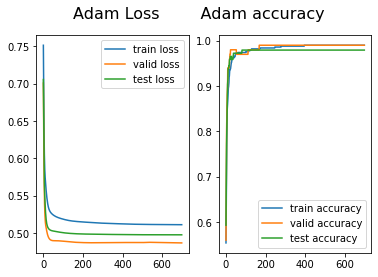

In [3]:
#DEFAULT VALUES FOR MODEL
beta1_default =  0.9
beta2_default = 0.999
epsilon_default = 1e-7
learning_rate_default = 0.001
batch_size_default = 500
#Part 2.1 and 2.2
#Default experiment for parts 2.1 and 2.2
trained_W, trained_b, predictions, trainTarget, l, optimizer, regularizer = buildGraph(batch_size_ = batch_size_default
              , beta1=beta1_default, beta2=beta2_default, epsilon= epsilon_default, learning_rate=learning_rate_default)


## 2.3 Batch Size Investigation

*   What is the impact of batch size on the final classification accuracy for each of the
3 cases?
  Generally speaking, batch size highly affects execution time and minima convergence, higher batch sizes allow for more probability of convergence to a global minima while being expensive computation wise and slower (the contrary applies to small batches). Depending on the batch size we can also influence a degree of generalization for data.
*   Can you justify this observation?

  It makes sense that bigger batches allow for a closer approximation of the 'gradient' of the loss function due to the sheer advantage in coverage of the data. For small batch sizes, their size allows for faster computation and converge. In the results below we can see that we were lucky enough to have a convergence to a very good minima in the training set with a batch size of 100, which in my opinion showed the best results for this part of the assignment:
  
  Final Training Loss 0.4918166697025299
  
  Final Validating Loss 0.48318809270858765

  Final Testing Loss 0.4999682307243347

  Final Training Accuracy 1.0

  Final Validating Accuracy 0.99

  Final Testing Accuracy 0.9724137931034482

Accuracies for all batch sizes are below, alongside their respective graphs



Loss at step 0: 0.8035150170326233
Training accuracy: 0.49
Validation accuracy: 0.51
Test accuracy: 0.5310344827586206
Loss at step 100: 0.4921226501464844
Training accuracy: 1.0
Validation accuracy: 0.97
Test accuracy: 0.9724137931034482
Loss at step 200: 0.4918917715549469
Training accuracy: 1.0
Validation accuracy: 0.98
Test accuracy: 0.9724137931034482
Loss at step 300: 0.4918268620967865
Training accuracy: 1.0
Validation accuracy: 0.98
Test accuracy: 0.9724137931034482
Loss at step 400: 0.49181437492370605
Training accuracy: 1.0
Validation accuracy: 0.99
Test accuracy: 0.9724137931034482
Loss at step 500: 0.49181461334228516
Training accuracy: 1.0
Validation accuracy: 0.99
Test accuracy: 0.9724137931034482
Loss at step 600: 0.4918387532234192
Training accuracy: 1.0
Validation accuracy: 0.99
Test accuracy: 0.9724137931034482
Final Training Loss 0.4918166697025299
Final Validating Loss 0.48318809270858765
Final Testing Loss 0.4999682307243347
Final Training Accuracy 1.0
Final Valida

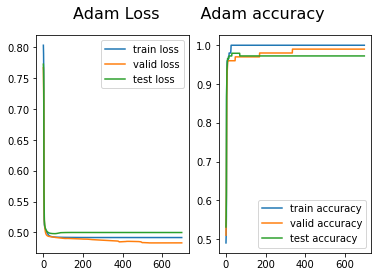

Loss at step 0: 0.5990948677062988
Training accuracy: 0.8428571428571429
Validation accuracy: 0.88
Test accuracy: 0.8620689655172413
Loss at step 100: 0.5235530138015747
Training accuracy: 0.9728571428571429
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Loss at step 200: 0.5193737745285034
Training accuracy: 0.9785714285714285
Validation accuracy: 0.98
Test accuracy: 0.9793103448275862
Loss at step 300: 0.5173499584197998
Training accuracy: 0.9828571428571429
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Loss at step 400: 0.5164387822151184
Training accuracy: 0.9842857142857143
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Loss at step 500: 0.5154052972793579
Training accuracy: 0.9885714285714285
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Loss at step 600: 0.5144893527030945
Training accuracy: 0.99
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Final Training Loss 0.5142058730125427
Final Validating Loss 0.48669219

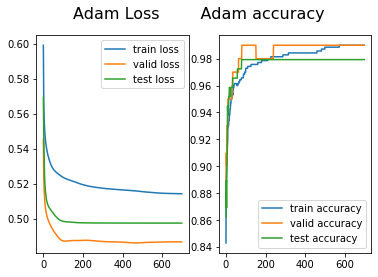

Loss at step 0: 0.7206056118011475
Training accuracy: 0.4617142857142857
Validation accuracy: 0.41
Test accuracy: 0.42758620689655175
Loss at step 100: 0.5223092436790466
Training accuracy: 0.964
Validation accuracy: 0.97
Test accuracy: 0.9724137931034482
Loss at step 200: 0.5177813768386841
Training accuracy: 0.9737142857142858
Validation accuracy: 0.98
Test accuracy: 0.9724137931034482
Loss at step 300: 0.5158824324607849
Training accuracy: 0.9777142857142858
Validation accuracy: 0.99
Test accuracy: 0.9724137931034482
Loss at step 400: 0.5143538117408752
Training accuracy: 0.98
Validation accuracy: 0.99
Test accuracy: 0.9724137931034482
Loss at step 500: 0.5133295059204102
Training accuracy: 0.984
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Loss at step 600: 0.5127729773521423
Training accuracy: 0.9845714285714285
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Final Training Loss 0.512364387512207
Final Validating Loss 0.48389971256256104
Final Testing Lo

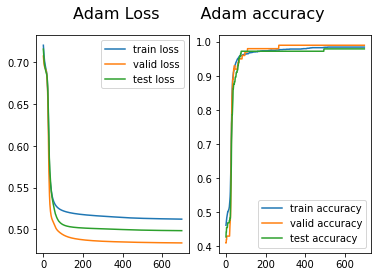

In [4]:
#2.3
#Batch Size Investigation (λ = 0 , α = 0.001)
# B = {100}
trained_W1, trained_b1, predictions1, trainTarget1, l1, optimizer1, regularizer1 = buildGraph(batch_size_ = 100
              , beta1=beta1_default, beta2=beta2_default, epsilon= epsilon_default, learning_rate=learning_rate_default)
# B = {700}
trained_W2, trained_b2, predictions2, trainTarget2, l2, optimizer2, regularizer2 = buildGraph(batch_size_ = 700
              , beta1=beta1_default, beta2=beta2_default, epsilon= epsilon_default, learning_rate=learning_rate_default)
# B = {1750}
trained_W3, trained_b3, predictions3, trainTarget3, l3, optimizer3, regularizer3 = buildGraph(batch_size_ = 1750
              , beta1=beta1_default, beta2=beta2_default, epsilon= epsilon_default, learning_rate=learning_rate_default)

## 2.4 Hyperparameter Investigation

Explain
which value you pick for hyperparameters in each part (a,b,c), and what accuracy you report:

###(a)


For part (a) I chose β1 = {0.99} due to the closeness of their accuracies, which generalizes more.

Accuracy for β1 = {0.95}

* Final Training Accuracy 0.994

* Final Validating Accuracy 0.99

* Final Testing Accuracy 0.9724137931034482

Accuracy for β1 = {0.99}

* Final Training Accuracy 0.988

* Final Validating Accuracy 0.98

* Final Testing Accuracy 0.9793103448275862

Accuracies are listed below alongside their respective graphs

Loss at step 0: 0.751790463924408
Training accuracy: 0.562
Validation accuracy: 0.63
Test accuracy: 0.6
Loss at step 100: 0.5177277326583862
Training accuracy: 0.978
Validation accuracy: 0.99
Test accuracy: 0.9655172413793104
Loss at step 200: 0.513034999370575
Training accuracy: 0.99
Validation accuracy: 0.99
Test accuracy: 0.9724137931034482
Loss at step 300: 0.5118800401687622
Training accuracy: 0.99
Validation accuracy: 0.99
Test accuracy: 0.9724137931034482
Loss at step 400: 0.5110992789268494
Training accuracy: 0.99
Validation accuracy: 0.99
Test accuracy: 0.9724137931034482
Loss at step 500: 0.5097190141677856
Training accuracy: 0.994
Validation accuracy: 0.99
Test accuracy: 0.9724137931034482
Loss at step 600: 0.5093995332717896
Training accuracy: 0.994
Validation accuracy: 0.99
Test accuracy: 0.9724137931034482
Final Training Loss 0.509164035320282
Final Validating Loss 0.4846706688404083
Final Testing Loss 0.5002609491348267
Final Training Accuracy 0.994
Final Validating Accu

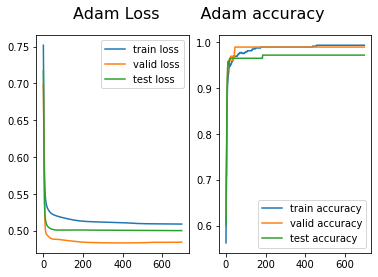

Loss at step 0: 0.6771029829978943
Training accuracy: 0.664
Validation accuracy: 0.74
Test accuracy: 0.7172413793103448
Loss at step 100: 0.5170822143554688
Training accuracy: 0.982
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Loss at step 200: 0.5148885250091553
Training accuracy: 0.984
Validation accuracy: 0.98
Test accuracy: 0.9793103448275862
Loss at step 300: 0.5133475661277771
Training accuracy: 0.986
Validation accuracy: 0.97
Test accuracy: 0.9793103448275862
Loss at step 400: 0.5127031207084656
Training accuracy: 0.986
Validation accuracy: 0.97
Test accuracy: 0.9793103448275862
Loss at step 500: 0.5121757388114929
Training accuracy: 0.988
Validation accuracy: 0.97
Test accuracy: 0.9793103448275862
Loss at step 600: 0.5120890736579895
Training accuracy: 0.988
Validation accuracy: 0.98
Test accuracy: 0.9793103448275862
Final Training Loss 0.5120955109596252
Final Validating Loss 0.4882911741733551
Final Testing Loss 0.49753043055534363
Final Training Accuracy 0.988

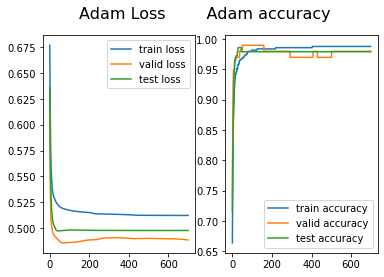

In [5]:
#2.4
#Hyperparameter Investigation (B = 500, λ = 0 , α = 0.001, epochs = 700 )
#(a) β1 = {0.95, 0.99}
trained_W4, trained_b4, predictions4, trainTarget4, l4, optimizer4, regularizer4 = buildGraph(batch_size_ = batch_size_default
              , beta1=0.95, beta2=beta2_default, epsilon= epsilon_default, learning_rate=learning_rate_default)
trained_W5, trained_b5, predictions5, trainTarget5, l5, optimizer5, regularizer5 = buildGraph(batch_size_ = batch_size_default
              , beta1=0.99, beta2=beta2_default, epsilon= epsilon_default, learning_rate=learning_rate_default)


###(b)


For part (b) I chose β2 = {0.99} due to the overall higher accuracies.

Accuracy for β2 = {0.99}
* Final Training Accuracy 0.992
* Final Validating Accuracy 0.98
* Final Testing Accuracy 0.9793103448275862

Accuracy for β2 = {0.9999}
* Final Training Accuracy 0.988
* Final Validating Accuracy 0.97
* Final Testing Accuracy 0.9724137931034482

Accuracies are listed below alongside their respective graphs

Loss at step 0: 0.7114957571029663
Training accuracy: 0.474
Validation accuracy: 0.4
Test accuracy: 0.45517241379310347
Loss at step 100: 0.5189140439033508
Training accuracy: 0.976
Validation accuracy: 0.98
Test accuracy: 0.9862068965517241
Loss at step 200: 0.5139508843421936
Training accuracy: 0.984
Validation accuracy: 0.98
Test accuracy: 0.9793103448275862
Loss at step 300: 0.5109686255455017
Training accuracy: 0.99
Validation accuracy: 0.98
Test accuracy: 0.9793103448275862
Loss at step 400: 0.5101237893104553
Training accuracy: 0.992
Validation accuracy: 0.98
Test accuracy: 0.9793103448275862
Loss at step 500: 0.5100098848342896
Training accuracy: 0.992
Validation accuracy: 0.98
Test accuracy: 0.9793103448275862
Loss at step 600: 0.5099782347679138
Training accuracy: 0.992
Validation accuracy: 0.98
Test accuracy: 0.9793103448275862
Final Training Loss 0.5099691152572632
Final Validating Loss 0.4890618622303009
Final Testing Loss 0.49735191464424133
Final Training Accuracy 0.992


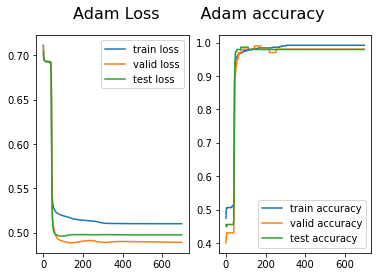

Loss at step 0: 0.8958562612533569
Training accuracy: 0.212
Validation accuracy: 0.19
Test accuracy: 0.2689655172413793
Loss at step 100: 0.518547534942627
Training accuracy: 0.98
Validation accuracy: 0.96
Test accuracy: 0.9724137931034482
Loss at step 200: 0.5155945420265198
Training accuracy: 0.984
Validation accuracy: 0.98
Test accuracy: 0.9724137931034482
Loss at step 300: 0.5143674612045288
Training accuracy: 0.986
Validation accuracy: 0.98
Test accuracy: 0.9724137931034482
Loss at step 400: 0.5137211680412292
Training accuracy: 0.986
Validation accuracy: 0.98
Test accuracy: 0.9724137931034482
Loss at step 500: 0.5133611559867859
Training accuracy: 0.986
Validation accuracy: 0.98
Test accuracy: 0.9724137931034482
Loss at step 600: 0.5130122900009155
Training accuracy: 0.986
Validation accuracy: 0.98
Test accuracy: 0.9724137931034482
Final Training Loss 0.5125307440757751
Final Validating Loss 0.4920523464679718
Final Testing Loss 0.49987539649009705
Final Training Accuracy 0.988
F

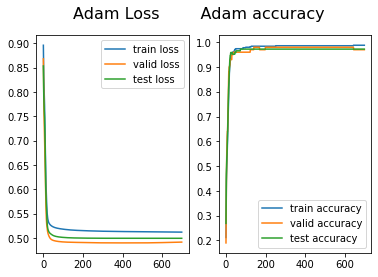

In [6]:
#(b) β2 = {0.99, 0.9999}
trained_W6, trained_b6, predictions6, trainTarget6, l6, optimizer6, regularizer6 = buildGraph(batch_size_ = batch_size_default
              , beta1=beta1_default, beta2=0.99, epsilon= epsilon_default, learning_rate=learning_rate_default)
trained_W7, trained_b7, predictions7, trainTarget7, l7, optimizer7, regularizer7 = buildGraph(batch_size_ = batch_size_default
              , beta1=beta1_default, beta2=0.9999, epsilon= epsilon_default, learning_rate=learning_rate_default)


###(c)


For part (c) I chose Epsilon = {1e − 09} for the stability of the accuracy (see graph below) and the overall higher accuracies in the validation and testing sets.

Accuracy for Epsilon = {1e − 09}
* Final Training Accuracy 0.986
* Final Validating Accuracy 0.99
* Final Testing Accuracy 0.9793103448275862

Accuracy for Epsilon = {1e − 4}
* Final Training Accuracy 0.99
* Final Validating Accuracy 0.96
* Final Testing Accuracy 0.9724137931034482

Accuracies are listed below alongside their respective graphs

Loss at step 0: 0.7554507255554199
Training accuracy: 0.502
Validation accuracy: 0.64
Test accuracy: 0.42758620689655175
Loss at step 100: 0.5200916528701782
Training accuracy: 0.972
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Loss at step 200: 0.5166100263595581
Training accuracy: 0.98
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Loss at step 300: 0.515005350112915
Training accuracy: 0.984
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Loss at step 400: 0.5141394734382629
Training accuracy: 0.986
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Loss at step 500: 0.5137833952903748
Training accuracy: 0.986
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Loss at step 600: 0.5135726928710938
Training accuracy: 0.986
Validation accuracy: 0.99
Test accuracy: 0.9793103448275862
Final Training Loss 0.5134422183036804
Final Validating Loss 0.4856109321117401
Final Testing Loss 0.49759364128112793
Final Training Accuracy 0.986


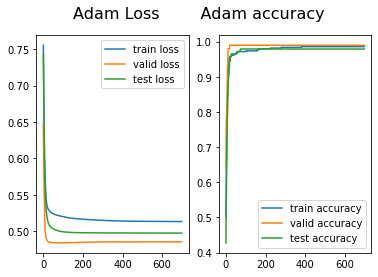

Loss at step 0: 0.6212669610977173
Training accuracy: 0.714
Validation accuracy: 0.7
Test accuracy: 0.6413793103448275
Loss at step 100: 0.5155236721038818
Training accuracy: 0.982
Validation accuracy: 0.97
Test accuracy: 0.9655172413793104
Loss at step 200: 0.5127056837081909
Training accuracy: 0.988
Validation accuracy: 0.97
Test accuracy: 0.9655172413793104
Loss at step 300: 0.511756181716919
Training accuracy: 0.988
Validation accuracy: 0.97
Test accuracy: 0.9724137931034482
Loss at step 400: 0.5110459327697754
Training accuracy: 0.99
Validation accuracy: 0.96
Test accuracy: 0.9724137931034482
Loss at step 500: 0.5108455419540405
Training accuracy: 0.99
Validation accuracy: 0.96
Test accuracy: 0.9724137931034482
Loss at step 600: 0.510646402835846
Training accuracy: 0.99
Validation accuracy: 0.96
Test accuracy: 0.9724137931034482
Final Training Loss 0.5103710889816284
Final Validating Loss 0.4948359429836273
Final Testing Loss 0.5003055334091187
Final Training Accuracy 0.99
Final V

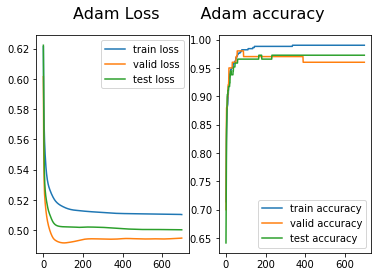

In [7]:
#(c) epsilon = {1e − 09, 1e − 4}
trained_W8, trained_b8, predictions8, trainTarget8, l8, optimizer8, regularizer8 = buildGraph(batch_size_ = batch_size_default
              , beta1=beta1_default, beta2=beta2_default, epsilon= 1e-09, learning_rate=learning_rate_default)
trained_W9, trained_b9, predictions9, trainTarget9, l9, optimizer9, regularizer9 = buildGraph(batch_size_ = batch_size_default
              , beta1=beta1_default, beta2=beta2_default, epsilon= 1e-4, learning_rate=learning_rate_default)

## 2.5 Comparison against Batch GD

Comment on the overall performance of the SGD
algorithm with Adam vs. the batch gradient descent algorithm you implemented earlier by
comparing plots of the losses and accuracies of the Adam vs. batch gradient descent:


*   Adam plots from part 2 show faster convergence to higher accuracy values overall and have plenty of parameters to configure to make sure your model performs the best it can. The SGD algorithm from part 1 often converges to lower values of accuracy (it is generally less noisy though) but the difference in performance compared to Adam clearly shows which optimizer returns the best results. Even though the tensorflow library is a bit special in the steps it takes to create models, it is easier to debug and harder to mess up in the logic of the code compared to a from scratch numpy implementation.

